In [80]:
import sys; sys.path.append('../rrr')
import decoy_mnist
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from itertools import cycle
plt.rcParams['text.usetex'] = True

In [5]:
Xr, X, y, E, Xtr, Xt, yt, Et = decoy_mnist.generate_dataset(cachefile='../data/decoy-mnist.npz')
Xr = np.array([x.ravel() for x in Xr])
Xtr = np.array([x.ravel() for x in Xtr])

# Loss Functions

All of the overcoming confounds and find-another-explanation analysis we've done in these experiments has used the following loss function, which regularizes the input gradient of a sum of log probabilities (under "right reasons"):

$$
\displaystyle L(\theta, X, y, A) = \underbrace{\sum_{n=1}^N\sum_{k=1}^K -y_{nk} \log(\hat{y}_{nk})}_{\text{Right answers}} + \displaystyle \underbrace{\lambda_1 \sum_{n=1}^N\sum_{d=1}^D \left(A_{nd}  \sum_{k=1}^K \frac{\partial}{\partial x_d} \log(\hat{y}_{nk}) \right)^2}_{\text{Right reasons}} + \displaystyle \underbrace{\lambda_2 \sum_{i} \theta_i^2}_{\text{Regularization}},
$$

where we have inputs and annotations $X, A \in \mathbb{R}^{N\times D}$, one-hot class labels and model predictions $y, \hat{y} \in \mathbb{R}^{N\times K}$, and model parameters $\theta$. We regularize the input gradients of the sum of log probabilities ($\nabla_X \sum_k\log\hat{y}_k$) in locations masked by $A$.

However, if we look at all the different options present in our [2D Intuition](2D%20Intuition.ipynb) visualizations, we could have also tried regularizing the gradient of the maximum (or specific classes, though in the multiclass case that would require many separate annotation matrices), and we could have used regular probabilities for each instead, e.g. $\nabla_X \max \log\hat{y}_k$, $\nabla_X \sum_k \hat{y}_k$, or any combination. We actually use the maximum for visualization everywhere because of its intuitive interpretation (gradients signify changes to the probability of the predicted class), so why not for regularization too?

It turns out that certain formulations are better for generating explanations and others are better for regularization. In a separate script, I generated models for the [Decoy MNIST](Decoy%20MNIST.ipynb) dataset using all four of those options (regular/log probabilities, penalties on sum/max) at two values of $\lambda_1$. Let's look at how they perform:

In [6]:
linmax_1000   = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_linmax_1000.pkl', 'rb')))
linsum_1000   = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_linsum_1000.pkl', 'rb')))
logmax_1000   = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_logmax_1000.pkl', 'rb')))
logsum_1000   = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_logsum_1000.pkl', 'rb')))
linmax_100000 = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_linmax_100000.pkl', 'rb')))
linsum_100000 = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_linsum_100000.pkl', 'rb')))
logmax_100000 = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_logmax_100000.pkl', 'rb')))
logsum_100000 = MultilayerPerceptron.from_params(pickle.load(open('../data/decoy_mnist_mlp_logsum_100000.pkl', 'rb')))

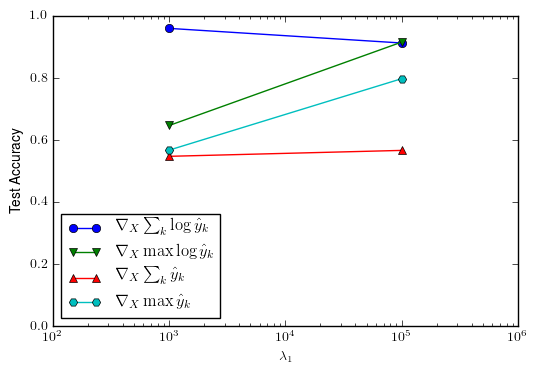

In [40]:
latex = {
  'logsum': r'$\nabla_X \sum_k \log \hat{y}_k$',
  'linmax': r'$\nabla_X \max \hat{y}_k$',
  'linsum': r'$\nabla_X \sum_k \hat{y}_k$',
  'logmax': r'$\nabla_X \max \log \hat{y}_k$'
}
markers = cycle('ov^H')
lmbdas = [1000, 100000]
for k, label in latex.items():
  scores = [eval('{}_{}'.format(k, lmb)).score(Xt, yt) for lmb in lmbdas]
  plt.plot(lmbdas, scores, label=label, marker=next(markers))
plt.legend(loc='best')
plt.ylim(0,1)
plt.xscale('log')
plt.xlim(100, 1000000)
plt.xlabel('$\lambda_1$')
plt.ylabel('Test Accuracy')
plt.show()

To fully investigate this we should probably run a lot more trials, maybe using a validation set to find the best value of $\lambda_1$, but we can say a few basic things:

- input-gradient-regularizing the sum of log probabilities appears to give us the best result and the one most robust to changing $\lambda_1$ (which ideally we don't have to worry about tuning too much).
- input-gradient-regularizing the sum of normal probabilities gives us the absolute _worst_ result. More on this later.
- regularizing the maximum (which we used throughout to visualize explanations) can be made to perform well, although it's best on log probabilities and also possibly more sensitive to $\lambda_1$ (although we should do more experiments in the future to verify this).

Let's test out these different forms of input gradients as explanation mechanisms now:

In [44]:
def explain(model, title='', length=4, fs=12, scale=None, y='max', i=0, Xt=Xt, **kwargs):
  plt.title(title, fontsize=fs)
  expls = model.grad_explain(Xt[i:i+length*length], scale=scale, y=y)                       
  explanation_grid(expls, (28,28), length, **kwargs)

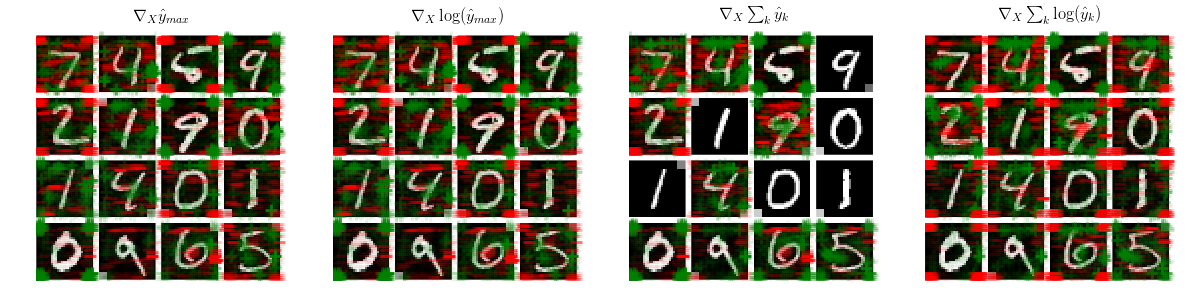

In [41]:
with figure_grid(1,4) as g:
  g.next(); explain(linsum_1000, r'$\nabla_X \hat{y}_{max}$', scale='lin')
  g.next(); explain(linsum_1000, r'$\nabla_X \log(\hat{y}_{max})$', scale='log')
  g.next(); explain(linsum_1000, r'$\nabla_X \textstyle\sum_k \hat{y}_k$', scale='lin', y='sum')
  g.next(); explain(linsum_1000, r'$\nabla_X \textstyle\sum_k \log(\hat{y}_k)$', scale='log', y='sum')

The above explanations are for a "bad" model, i.e. one that gets about 55% test accuracy due to the decoy rule.

We can see that the explanations for the maximum $\hat{y}$ (i.e. explanations for the predicted class) largely agree for log probabilities and regular probabilities; it's hard to see much of a difference in their direction (although their magnitudes probably differ both across methods and examples; see [2D Intuition](2D%20Intuition.ipynb)).

There is a significant difference between explanations using the gradient of the sum of $\hat{y}_k$s. We actually see that using regular probabilities often cancel out entirely, leading to blank spots. This is especially evident for binary datasets, where increasing the probability of one class decreases the probability of the other by exactly the same amount. In log space this isn't as much of an issue. However, if you examine the signs of the gradients for the sum vs. the maximums, you see that they're different. To get a sense of why this might be, let's look at explanations for one of the examples where signs flip, but for each class individually:

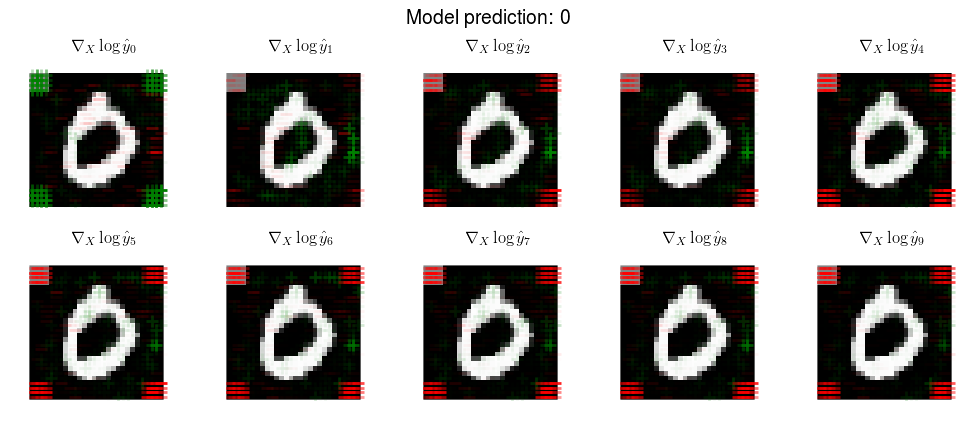

In [74]:
with figure_grid(2,5, rowheight=2, rowwidth=10) as g:
  ex = 3
  g.title('Model prediction: {}'.format(linsum_1000.predict(Xt[ex:ex+1])[0]))
  for i, ax in enumerate(g.each_subplot()):
    explain(linsum_1000, r'$\nabla_X \log \hat{{y}}_{{{}}}$'.format(i), length=1, y=i, i=ex, scale='log', pwr=2)

This is an example the model got right, even though the swatch color was wrong. The "right" swatch color for 0 is 255, or white, so it makes sense that increasing the swatch shade higher would increase the probability of 0. This in turn should _decrease_ the probability of the other classes, although the effect isn't as strong for low digits, e.g. 1, which also benefit.

If we sum these, we get negative weights in the swatches, even though the weights for the predicted class, 0, are positive. That should hopefully help to build intuition about what information the maximum and sum represent.

In terms of figuring out the best loss function to use, in this work, we've really only explored a few possibilities. In general, we might consider input gradient penalties that are class-specific or constrain weights to be non-negative or non-positive, rather than near zero. We can also consider different penalty norms, higher-order derivatives, or derivatives with respect to complex transformations of our inputs (e.g. global brightening). The overarching goal should be to find simple mathematical ways to express intuitive, domain- and example-specific invariants. Given enough of them, hopefully the only models that emerge from our optimization -- the only models consistent with our explanations -- are right for the right reasons.